In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def clean_text(text):
    # Ensure consistent spacing after titles like "Item 1A."
    text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
    # Insert missing spaces between concatenated words like "FactorsThe"
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    # Clean up spacing after punctuation
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
    return text.strip()

def split_sentences_with_nltk(text):
    # Initial cleaning
    text = clean_text(text)

    # Use nltk's sentence tokenizer
    sentences = nltk.sent_tokenize(text)

    # Post-process to remove redundant or empty sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

[nltk_data] Downloading package punkt to /Users/ajaymdn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def converttotext(url):
    headers = {'User-Agent':'Sample Company Name AdminContact@<sample company domain>.com','Accept-Encoding':'gzip, deflate','Host':'www.sec.gov'}

    r = requests.get(url, headers=headers)

    raw_10k = r.text

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|7A|7|8))')

    matches = regex.finditer(document['10-K'])

    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()
    test_df.head()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace(' ','',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace('>','',regex=True,inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]

    item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')

    item_1a_text = item_1a_content.get_text()

    sentences = split_sentences_with_nltk(item_1a_text)
    
    return sentences


In [10]:
def load_esg_dictionaries(json_file_path="words.json"):
    with open(json_file_path, 'r') as file:
        esg_dictionaries = json.load(file)
    return esg_dictionaries

In [11]:
def preprocess_text(text):
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

In [12]:
from typing import Counter

def analyze_esg(text, esg_dictionaries):
    text = preprocess_text(text)
    word_counts = Counter(text.split())
    
    # Initialize scores for Environmental, Social, and Governance
    environmental_score = 0
    social_score = 0
    governance_score = 0
    
    # Calculate the scores based on the keyword matches
    for keyword in esg_dictionaries['Environmental']:
        environmental_score += word_counts.get(keyword, 0)
    for keyword in esg_dictionaries['Social']:
        social_score += word_counts.get(keyword, 0)
    for keyword in esg_dictionaries['Governance']:
        governance_score += word_counts.get(keyword, 0)
    
    # Normalize the scores by the total word count
    total_words = sum(word_counts.values())
    if total_words > 0:
        environmental_score /= total_words
        social_score /= total_words
        governance_score /= total_words
    
    # Return the individual ESG scores (normalized)
    return {
        'environment_score_avg': environmental_score,
        'social_score_avg': social_score,
        'governance_score_avg': governance_score
    }

In [13]:
# esg_dictionaries = load_esg_dictionaries()
# text = converttotext("https://www.sec.gov/Archives/edgar/data/1018724/000101872420000004/0001018724-20-000004.txt")
# environmental, social, governance = analyze_esg(" ".join(text), esg_dictionaries)



In [18]:
years = range(2014, 2025)
industry = "OIL"

esg_dictionaries = load_esg_dictionaries()

environmental_scores = []
social_scores = []
governance_scores = []

for target_year in years:
    print(f"Processing: {target_year}")

    try:
        with open(f"../Edgar/10K_URL_{industry}/All_10K_Filings_{target_year}.json", "r") as read_file:
            companies = json.load(read_file)

        valid_companies = []

        for company in companies:
            try:
                # print(f"Analysing: {company['company']}")
                sentences = converttotext(company['url'])
                print(f"Company: {company['company']}, Sentence count: {len(sentences)}")

                if len(sentences) > 10:
                    scores = analyze_esg(" ".join(sentences), esg_dictionaries)
                
                    company['environment_score_avg'] = scores['environment_score_avg']
                    company['social_score_avg'] = scores['social_score_avg']
                    company['governance_score_avg'] = scores['governance_score_avg']
                
                    valid_companies.append(company)

            except Exception as e:
                print(f"Error processing {company['company']}: {e}")
        
        final_companies = [company['company'] for company in valid_companies]
        print(f"Companies processed: {final_companies}")


        if valid_companies:
            environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
            social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
            governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

            # print(f'Average Environmental Score: {environment_avg}')
            # print(f'Average Social Score: {social_avg}')
            # print(f'Average Governance Score: {governance_avg}')

            environmental_scores.append(environment_avg)
            social_scores.append(social_avg)
            governance_scores.append(governance_avg)

    except Exception as e:
        print(f"Error processing year {target_year}: {e}")

Processing: 2014
Company: XOM, Sentence count: 2
Error processing CVX: 'item1b'
Company: COP, Sentence count: 62
Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 48
Company: PSX, Sentence count: 183
Company: MPC, Sentence count: 208
Error processing VLO: 'item1a'
Error processing HES: 'item1b'
Company: DVN, Sentence count: 100
Company: KMI, Sentence count: 327
Company: WMB, Sentence count: 268
Error processing HAL: 'item1a'
Company: EXE, Sentence count: 811
Companies processed: ['COP', 'OXY', 'PSX', 'MPC', 'DVN', 'KMI', 'WMB', 'EXE']
Processing: 2015
Company: XOM, Sentence count: 2
Company: CVX, Sentence count: 50
Company: COP, Sentence count: 64
Error processing EOG: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: OXY, Sentence count: 59
Company: PSX, Sentence count: 182
Company: MPC, Sentence count: 246
Company: VLO, Sentence count: 138
Error processing HES: 'item1b'
Compan

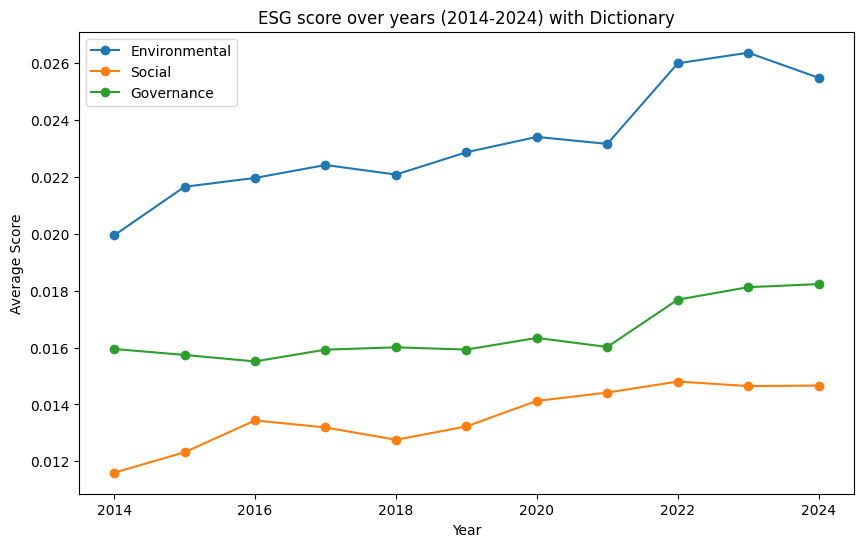

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(years, environmental_scores, label='Environmental', marker='o')
plt.plot(years, social_scores, label='Social', marker='o')
plt.plot(years, governance_scores, label='Governance', marker='o')

plt.title("ESG score over years (2014-2024) with Dictionary")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend()
plt.show()